In [2]:
# imports!
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

Obtain Dataset (cifar 10)

In [3]:
# from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


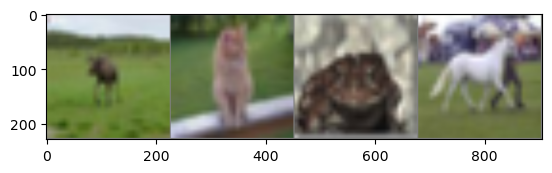

deer  cat   frog  horse


In [4]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Image Embedding

In [ ]:
# Hayley and Mukta
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()

        # Self-attention and feedforward layers
        # makes "depth" many transformer layers
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=dim, 
                nhead=heads, 
                dim_feedforward=mlp_dim, 
                dropout=dropout,
                norm_first=True
            ) for _ in range(depth)
        ])

        # stacks all the layers together
        self.transformer_encoder = nn.TransformerEncoder(self.layers, num_layers=depth)

    def forward(self, x):
        # Forward pass through transformer encoder
        x = self.transformer_encoder(x)
        return x

class Vit(nn.Module):

  def __init__(self, *,
               image_size, patch_size, num_classes,
               dim, depth, heads, mlp_dim):

    channels = 3
    pool = 'cls'
    dim_head = 64
    dropout, emb_dropout = (0., 0.)

    super().__init__()

    # split an image into fixed-size patches
    image_width, image_height = (image_size, image_size)

    # Ensure that we can split the images into equal patches
    assert image_height % patch_size == 0 and image_width % patch_size == 0, 'Image dimensions must be divisible by the patch size.'

    num_patches = (image_height // patch_size) * (image_width // patch_size)
    patch_dim = channels * patch_size * patch_size

    # linearly embed each of them
    self.to_patch_embedding = nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
        nn.LayerNorm(patch_dim),
        nn.Linear(patch_dim, dim),
        nn.LayerNorm(dim),
    )
    # add position embeddings
    self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
    # represents the class of the object in the image. 
    self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
    
    self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
    # we cannot use the torch.nn.Transformer class because this class has encoder
    # and decoder layers. Our implementation should only have encoder layers.

def forward(self, img):
    
    #self.dropout = nn.Dropout(emb_dropout)
    x = self.to_patch_embedding(img)
    b, n, _ = x.shape
    cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
    x = torch.cat((cls_tokens, x), dim=1)
    x += self.pos_embedding[:, :(n+1)]
    #dropout can go here x=self.dropout(x)
    # feed the resulting sequence of vectors to a standard Transformer encoder
    x = self.transformer(x)
    
    
    
    
# feed the resulting sequence of vectors to a standard Transformer encoder
# to perform classification, use the standard approach of adding an extra learnable "classification token" to the sequence.

Encoder

In [ ]:
# Francine and Sophie

# using vit model in pytorch https://pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16
# other vision tranformer model to try maybe: https://pytorch.org/tutorials/beginner/vt_tutorial.html

# model = Vit(
#     image_size,
#     patch_size,
#     num_classes,
#     dim, depth, heads,
#     dropout, emb_dropout,
#     pool = cls or mean
# )

# takes too long to run, will try running on server

model = torchvision.models.vit_b_16(weights ='DEFAULT')

# idk if this is right
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(trainloader)}')

# Evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Classification

Evaluation